#Face identification model using transfer learning(VGG16)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls '/content/drive'

MyDrive


In [3]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
#Give dataset path
train_path = '/content/drive/MyDrive/celeb_data/train'
test_path = '/content/drive/MyDrive/celeb_data/test'

In [5]:
IMAGE_SIZE = [224, 224]

Working with 75 images
Image examples: 
Shahruk Khan138.jpg


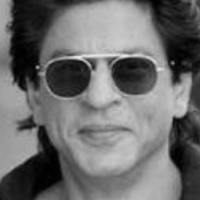

Shahruk Khan141.jpg


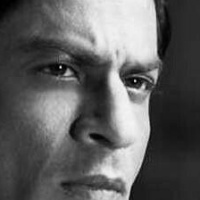

Shahruk Khan137.jpg


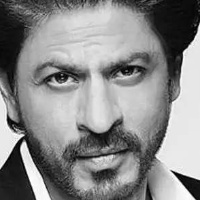

Shahruk Khan139.jpg


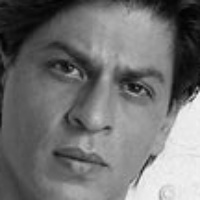

Shahruk Khan134.jpg


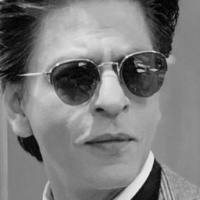

In [6]:
from PIL import Image 
import os 
from IPython.display import display
from IPython.display import Image as _Imgdis
# creating a object  
  
folder = train_path+'/Shahruk Khan'

y = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
print("Working with {0} images".format(len(y)))
print("Image examples: ")

for i in range(5):
    print(y[i])
    display(_Imgdis(filename=folder + "/" + y[i], width=240, height=240))

##Creating VGG16 Model


In [38]:
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [39]:
vgg.input

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_5')>

Using Fine tuning upto last three layers

In [40]:
#Fine Tuning
for layer in vgg.layers[:-3]:
  layer.trainable = False

In [41]:
folders = glob('/content/drive/MyDrive/celeb_data/train/*')
print(len(folders))

10


In [42]:
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D


x = GlobalAveragePooling2D()(vgg.output)
x = Dense(256,activation='relu')(x)
x = Dropout(0.2)(x) #to avoid overfitting
prediction = Dense(len(folders), activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

##Fine-tuning model with a lower learning rate, which will help the Fully-Connected layer "warm-up" and learn robust patterns

In [44]:
from keras import optimizers

adam = optimizers.Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

Applying multiple augmentations to our training data for all images. ImageDataGenerator lets us easily load batches of data for training using the flow_from_directory method. Our directories holding the training and testing data are structured perfectly for this method, which requires the input images to be housed in subdirectories corresponding to their class label.

In [45]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    validation_split=0.15,
    horizontal_flip=True,
    fill_mode='nearest')  

In [46]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [47]:
class_subset = class_subset = sorted(os.listdir('/content/drive/MyDrive/celeb_data/train/'))

In [48]:
BATCH_SIZE = 64
traingen = train_datagen.flow_from_directory(train_path,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='training',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

validgen = train_datagen.flow_from_directory(train_path,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

testgen = test_datagen.flow_from_directory(test_path,
                                             target_size=(224, 224),
                                             class_mode=None,
                                             classes=class_subset,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

Found 638 images belonging to 10 classes.
Found 110 images belonging to 10 classes.
Found 246 images belonging to 10 classes.


In [18]:
n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 100

In [19]:
!pip install livelossplot

In [49]:
from livelossplot.inputs.keras import PlotLossesCallback
from keras.callbacks import ModelCheckpoint, EarlyStopping

plot_loss_75 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')


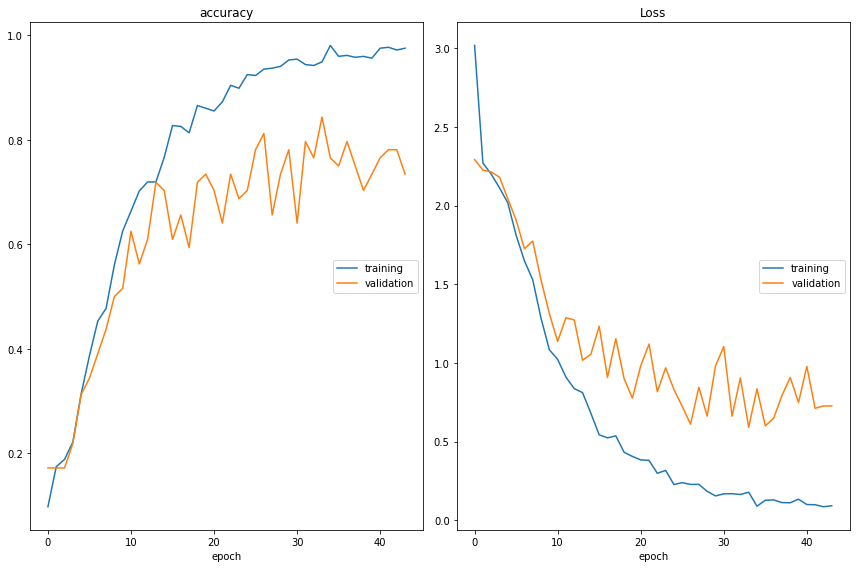

accuracy
	training         	 (min:    0.098, max:    0.981, cur:    0.976)
	validation       	 (min:    0.172, max:    0.844, cur:    0.734)
Loss
	training         	 (min:    0.086, max:    3.017, cur:    0.092)
	validation       	 (min:    0.590, max:    2.292, cur:    0.727)


In [50]:
vgg_history = model.fit(traingen,#validgen
                        batch_size=BATCH_SIZE,
                        epochs=n_epochs,
                        validation_data=validgen,
                        steps_per_epoch=n_steps,
                        validation_steps=n_val_steps,
                        callbacks=[tl_checkpoint_1, early_stop, plot_loss_75],
                        verbose=1)

In [51]:
# Generate predictions
model.load_weights('tl_model_v1.weights.best.hdf5') # initialize the best trained weights

true_classes = testgen.classes
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

vgg_preds = model.predict(testgen)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)

In [52]:
from sklearn.metrics import confusion_matrix , classification_report

print(classification_report(true_classes,vgg_pred_classes))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        24
           1       0.96      0.92      0.94        25
           2       0.96      1.00      0.98        24
           3       0.96      1.00      0.98        25
           4       1.00      1.00      1.00        23
           5       1.00      1.00      1.00        25
           6       0.89      1.00      0.94        25
           7       1.00      0.92      0.96        25
           8       1.00      0.96      0.98        25
           9       0.95      0.84      0.89        25

    accuracy                           0.96       246
   macro avg       0.97      0.96      0.96       246
weighted avg       0.96      0.96      0.96       246



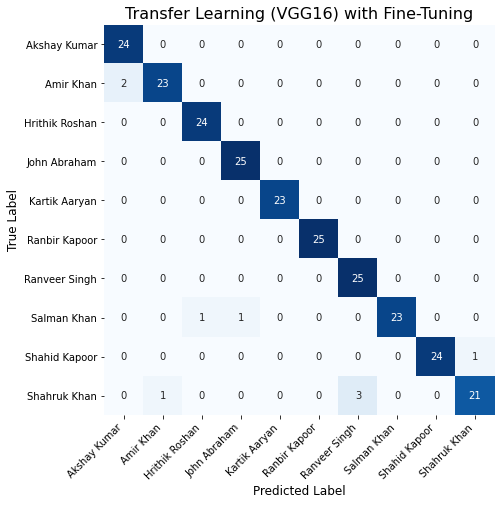

In [53]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the names of the ten classes
class_names = testgen.class_indices.keys()

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, (ax1) = plt.subplots(1, 1, figsize=(7,7))
 
plot_heatmap(true_classes, vgg_pred_classes, class_names, ax1, title="Transfer Learning (VGG16) with Fine-Tuning")    


fig.tight_layout()
fig.subplots_adjust(top=1.25)
plt.show()


In [54]:
from sklearn.metrics import accuracy_score

vgg_acc = accuracy_score(true_classes, vgg_pred_classes)
print("VGG16 Model(with fine tuning) Accuracy: {:.2f}%".format(vgg_acc * 100))

VGG16 Model(with fine tuning) Accuracy: 96.34%
